In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error

import torch
import torch.nn as nn

from keras import layers
import tensorflow as tf
import tensorflow_probability as tfp

import keras 
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Reading data

In [5]:
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')
submission_data = pd.read_csv('data/sample_submission.csv')

test_data = test_data.astype(np.float64).drop(["id"], axis=1)
train_data = train_data.astype(np.float64).drop(["id"], axis=1)

print("train_data.shape: ", train_data.shape)

print("train_data.shape: ", train_data.shape)


train_data.shape:  (10407, 12)
train_data.shape:  (10407, 12)


**Add other data from another data source**

In [6]:
# Crystal_data = pd.read_csv('data/Artificial_Crystals_Dataset.csv').drop(["Formula","Crystal structure","Unnamed: 0"], axis=1).rename(columns={"Hardness (Mohs)":"Hardness"}).astype(np.float64)
# Mineral_data = pd.read_csv('data/Mineral_Dataset_Supplementary_Info.csv').drop(["Unnamed: 0"], axis=1).astype(np.float64)

# train_data = pd.concat([train_data, Crystal_data, Mineral_data], axis=0)
# print("train_data.shape: ", train_data.shape)

### Does not improve the score of the model so we won't use it

In [7]:
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


# Data Preprocessing/ Cleaning

**Data Cleaning with LFO**

In [8]:
print(f"Shape of train data before removing outliers: {train_data.shape}")
print(f"Shape of test data before removing outliers: {test_data.shape}")

clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
train_data_without_outlier = clf.fit_predict(train_data)
train_data = train_data[train_data_without_outlier == 1]

print("Shape of train data after removing outliers: ", train_data.shape)
print("Shape of test data after removing outliers: ", test_data.shape)

Shape of train data before removing outliers: (10407, 12)
Shape of test data before removing outliers: (6939, 11)
Shape of train data after removing outliers:  (9366, 12)
Shape of test data after removing outliers:  (6939, 11)


**Data Cleaning with IQR**

In [9]:
print(f"Shape of train data before removing outliers: {train_data.shape}")
print(f"Shape of test data before removing outliers: {test_data.shape}")

for i in train_data.columns: 
    if i=="Hardness":
        continue
    Q1 = train_data[i].quantile(0.25)
    Q3 = train_data[i].quantile(0.75)
    IQR = Q3-Q1
    upper_limit = Q3+1.5*IQR
    lower_limit = Q1-1.5*IQR 
    train_data[i].clip(lower = lower_limit,upper = upper_limit,inplace=True)   
    test_data[i].clip(lower = lower_limit,upper = upper_limit,inplace=True)
    
print(f"Shape of train data after removing outliers: {train_data.shape}")
print(f"Shape of test data after removing outliers: {test_data.shape}")

Shape of train data before removing outliers: (9366, 12)
Shape of test data before removing outliers: (6939, 11)
Shape of train data after removing outliers: (9366, 12)
Shape of test data after removing outliers: (6939, 11)


### We can see that the cleaning of the data make the prediction worst. So we will not use it.

<Axes: >

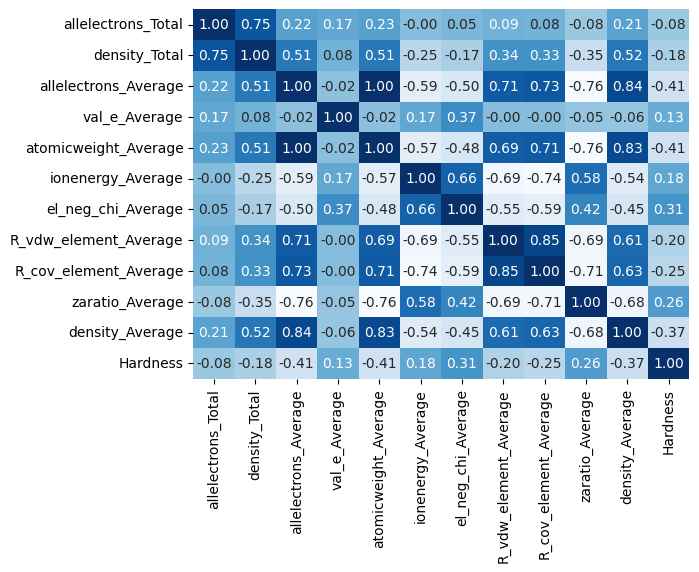

In [10]:
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='Blues', cbar=False)

# Basic Model training

In [37]:
# Splitting the data into train and test
X = train_data.drop('Hardness', axis=1)
y = train_data['Hardness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Testing different models of ML

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
    'LGBMRegressor': LGBMRegressor(verbose=0),
    'XGBRegressor': XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor(),
    'VotingRegressor': VotingRegressor([('xgboost', XGBRegressor()), ('rf', RandomForestRegressor()), ('lgbm', LGBMRegressor(verbose = 0)), ('catboost', CatBoostRegressor())])
}

best_model = None
best_score = float('inf')

for model_name, model in models.items():
    medae = median_absolute_error(y, cross_val_predict(model, X, y, cv=5, n_jobs=-1))
    print(f'{model_name} MedAE: {medae}')
    
    if medae < best_score:
        best_score = medae
        best_model = model_name

print("-"*50,sep="")
print(f'Best model: {best_model}')
print(f'Best MAE: {best_score}')

LinearRegression MedAE: 0.9626377452569286
Ridge MedAE: 0.9614135374368575
Lasso MedAE: 1.0595999555863846
ElasticNet MedAE: 1.040384394130053
BayesianRidge MedAE: 0.9606530362984984
RandomForestRegressor MedAE: 0.6449999999999996
GradientBoostingRegressor MedAE: 0.6948614878240233
KNeighborsRegressor MedAE: 0.7200000000000002
SVR MedAE: 0.7723838457255585
LGBMRegressor MedAE: 0.6482110666791201
XGBRegressor MedAE: 0.6656471729278564
CatBoostRegressor MedAE: 0.6544929658175831
VotingRegressor MedAE: 0.6356329896201469
--------------------------------------------------
Best model: VotingRegressor
Best MAE: 0.6356329896201469


In [13]:
# Evaluate the best model on the test set
model = VotingRegressor([('xgboost', XGBRegressor()), ('rf', RandomForestRegressor()), ('lgbm', LGBMRegressor(verbose = 0)), ('catboost', CatBoostRegressor())])
model.fit(X_train, y_train)
print(f'Train MAE: {median_absolute_error(y_train, model.predict(X_train))}')
print(f'Test MAE: {median_absolute_error(y_test, model.predict(X_test))}')

Learning rate set to 0.056282
0:	learn: 1.6195280	total: 149ms	remaining: 2m 28s
1:	learn: 1.5934836	total: 157ms	remaining: 1m 18s
2:	learn: 1.5663468	total: 163ms	remaining: 54.3s
3:	learn: 1.5420940	total: 169ms	remaining: 42.1s
4:	learn: 1.5201034	total: 174ms	remaining: 34.6s
5:	learn: 1.5003230	total: 178ms	remaining: 29.4s
6:	learn: 1.4818183	total: 181ms	remaining: 25.7s
7:	learn: 1.4641039	total: 186ms	remaining: 23s
8:	learn: 1.4487259	total: 189ms	remaining: 20.8s
9:	learn: 1.4351071	total: 192ms	remaining: 19s
10:	learn: 1.4223910	total: 195ms	remaining: 17.5s
11:	learn: 1.4091331	total: 197ms	remaining: 16.2s
12:	learn: 1.3985355	total: 202ms	remaining: 15.3s
13:	learn: 1.3887130	total: 205ms	remaining: 14.4s
14:	learn: 1.3796736	total: 207ms	remaining: 13.6s
15:	learn: 1.3707416	total: 210ms	remaining: 12.9s
16:	learn: 1.3627491	total: 214ms	remaining: 12.4s
17:	learn: 1.3542429	total: 217ms	remaining: 11.8s
18:	learn: 1.3470872	total: 222ms	remaining: 11.4s
19:	learn: 1.

In [14]:
class_weight = model.estimators_[2].booster_.feature_importance(importance_type='gain')

In [15]:
# Train model on full data
model = models[best_model]
model.fit(X, y)
predictions = model.predict(test_data)

# Create submission file
submission = pd.DataFrame(submission_data['id'])
submission['Hardness'] = predictions
submission.to_csv('submission_data/submission.csv', index=False)

Learning rate set to 0.058302
0:	learn: 1.6207018	total: 3.54ms	remaining: 3.53s
1:	learn: 1.5931531	total: 6.59ms	remaining: 3.29s
2:	learn: 1.5657689	total: 9.88ms	remaining: 3.28s
3:	learn: 1.5398778	total: 13.3ms	remaining: 3.31s
4:	learn: 1.5168575	total: 17.2ms	remaining: 3.43s
5:	learn: 1.4968536	total: 20.6ms	remaining: 3.41s
6:	learn: 1.4765867	total: 24.2ms	remaining: 3.44s
7:	learn: 1.4586465	total: 27.6ms	remaining: 3.42s
8:	learn: 1.4431921	total: 31.2ms	remaining: 3.44s
9:	learn: 1.4289960	total: 34.5ms	remaining: 3.41s
10:	learn: 1.4160158	total: 37.5ms	remaining: 3.37s
11:	learn: 1.4030869	total: 40.9ms	remaining: 3.37s
12:	learn: 1.3918869	total: 44.4ms	remaining: 3.37s
13:	learn: 1.3822048	total: 47.6ms	remaining: 3.35s
14:	learn: 1.3726066	total: 50.7ms	remaining: 3.33s
15:	learn: 1.3631089	total: 53.7ms	remaining: 3.3s
16:	learn: 1.3543251	total: 57.4ms	remaining: 3.32s
17:	learn: 1.3463852	total: 60.6ms	remaining: 3.31s
18:	learn: 1.3385812	total: 63.6ms	remaining:

# Deep Learning Model

In [16]:
# Definition of the loss function and the metric
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [42]:
# Definition of the model and training
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    # layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(254, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(254, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(508, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss='mean_absolute_error',
                metrics= ['mean_absolute_error'])

early_stopping = EarlyStopping(monitor="val_loss", patience=40)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

model.fit(X, y, epochs=1000, batch_size=1000, callbacks=[early_stopping, reduce_lr], validation_split=0.2)

Epoch 1/1000
8/8 [==============================] - 3s 88ms/step - loss: 2.8263 - mean_absolute_error: 2.8263 - val_loss: 6.8780 - val_mean_absolute_error: 6.8780 - lr: 0.0100
Epoch 2/1000
8/8 [==============================] - 0s 26ms/step - loss: 1.5270 - mean_absolute_error: 1.5270 - val_loss: 1.4219 - val_mean_absolute_error: 1.4219 - lr: 0.0100
Epoch 3/1000
8/8 [==============================] - 0s 40ms/step - loss: 1.2262 - mean_absolute_error: 1.2262 - val_loss: 1.5954 - val_mean_absolute_error: 1.5954 - lr: 0.0100
Epoch 4/1000
8/8 [==============================] - 0s 24ms/step - loss: 1.1083 - mean_absolute_error: 1.1083 - val_loss: 2.2298 - val_mean_absolute_error: 2.2298 - lr: 0.0100
Epoch 5/1000
8/8 [==============================] - 0s 28ms/step - loss: 1.0152 - mean_absolute_error: 1.0152 - val_loss: 2.2717 - val_mean_absolute_error: 2.2717 - lr: 0.0100
Epoch 6/1000
8/8 [==============================] - 0s 27ms/step - loss: 0.9668 - mean_absolute_error: 0.9668 - val_loss

In [34]:
# Evaluate the best model on the test set and create submission file
predictions_DL = model.predict(test_data)
submission = pd.DataFrame(submission_data['id'])
submission['Hardness'] = predictions_DL
submission.to_csv('submission_data/submission_deep_learning.csv', index=False)

217/217 [==============================] - 1s 2ms/step
